<a href="https://colab.research.google.com/github/shnhrtkyk/memo/blob/main/semseg_trial_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(42)

cuda


In [3]:
im_width = 512
im_height = 512
im_chan = 3

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_train = '/content/drive/MyDrive/train'
path_test = '/content/drive/MyDrive/test'
path_valid = '/content/drive/MyDrive/validation'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

valid_path_images = os.path.abspath(path_valid + "/images/")
valid_path_masks = os.path.abspath(path_valid + "/masks/")

In [6]:
train_path_images_list = glob(os.path.join(train_path_images, "*.tif"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.tif"))
test_path_images_list = glob(os.path.join(test_path_images, "*.tif"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.tif"))
valid_path_images_list = glob(os.path.join(valid_path_images, "*.tif"))
valid_path_masks_list = glob(os.path.join(valid_path_masks, "*.tif"))

In [7]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]
valid_ids = next(os.walk(valid_path_images))[2]

In [85]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width), dtype=np.bool_)

print('Getting training data...')

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = cv2.imread(path_train + '/images/' + id_)
    img = cv2.medianBlur(img,5)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    X_train[n] = img
    
    mask = cv2.imread(path_train + '/masks/' + id_)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # print(np.unique(mask/255.0))
    # print(mask.shape)
    Y_train[n] = mask/255.0
    # u, counts = np.unique(Y_test[n], return_counts=True)
    # print(counts) 
    
print('Done!')

Getting training data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Done!


In [86]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), im_height, im_width), dtype=np.bool_)

print('Getting testing data...')

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    img = cv2.imread(path_test + '/images/' + id_)
    img = cv2.medianBlur(img,5)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    X_test[n] = img
    
    mask = cv2.imread(path_test + '/masks/' + id_)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = np.resize(mask,(512,512))
    Y_test[n] = mask/255.0
    # u, counts = np.unique(Y_test[n], return_counts=True)
    # print(counts)

print('Done!')

Getting testing data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Done!


In [87]:
X_valid = np.zeros((len(valid_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_valid = np.zeros((len(valid_ids), im_height, im_width), dtype=np.bool_)

print('Getting validation data...')

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(valid_ids), total=len(valid_ids)):
    img = cv2.imread(path_valid + '/images/' + id_)
    img = cv2.medianBlur(img,5)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    X_valid[n] = img
    
    mask = cv2.imread(path_valid + '/masks/' + id_)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = np.resize(mask,(512,512))
    Y_valid[n] = mask/255.0
    # u, counts = np.unique(Y_valid[n], return_counts=True)
    # print(counts)

    
print('Done!')

Getting validation data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Done!


In [88]:
from IPython.display import display

class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (256, 256))
        mask = TF.center_crop(mask, (256, 256))

        #display(image)
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask    


In [124]:
train_dataset = Nuc_Seg(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

test_dataset = Nuc_Seg(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = True)

valid_dataset = Nuc_Seg(X_valid, Y_valid)
valid_loader = DataLoader(valid_dataset, batch_size = 4, shuffle = True)

Feature batch shape: torch.Size([4, 3, 256, 256])
Labels batch shape: torch.Size([4, 1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([256, 256])


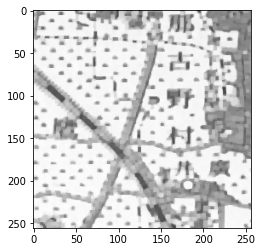

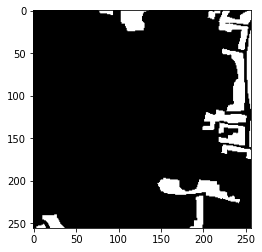

In [125]:
train_features, train_labels = next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
print(img.shape)
print(label.shape)
plt.imshow(  img.permute(1, 2, 0)  )
plt.show()

plt.imshow(label, cmap = "gray")
plt.show()

In [126]:
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
      pred_inds = pred == cls
      target_inds = target == cls
      intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
      union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
    
      if union == 0:
        iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
      else:
        iou.append(float(intersection) / float(max(union, 1)))
     
    return sum(iou)

In [127]:
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

In [128]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [129]:
import torch
import torch.nn as nn


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(2)
model = model.to(device)

device cuda


In [140]:
from collections import defaultdict
import torch.nn.functional as F

weights = torch.tensor([10.,1.])
weights = torch.FloatTensor(weights).cuda()

critic = nn.CrossEntropyLoss(weight=weights)


def dice_loss(pred, target, smooth = 1.):
    pred = pred[:,1,:,:].contiguous()
    target = target.contiguous()    
    # print(pred.size())
    # print(target.size())

    intersection = (pred * target).sum(dim=1).sum(dim=1)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + target.sum(dim=1).sum(dim=1) + smooth)))
    
    return loss.mean()

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = critic(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = valid_loader

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()[:,0,:,:]
                # labels = torch.eye(2)[labels.long()]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                image_val_ = inputs[0].squeeze().cpu()
                plt.subplot(1,3,1)
                plt.imshow( image_val_.permute(1, 2, 0)  )
                
                outputs_ = outputs[0].squeeze().cpu()
                plt.subplot(1,3,2)
                plt.imshow(outputs_[1])

                mask_val_ = labels[0].squeeze().cpu()
                plt.subplot(1,3,3)
                plt.imshow(mask_val_)
                plt.show()

                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

Epoch 0/99
----------
train: bce: 0.136835, dice: 0.874223, loss: 0.505529
LR 0.0001
val: bce: 0.065552, dice: 0.860217, loss: 0.462884


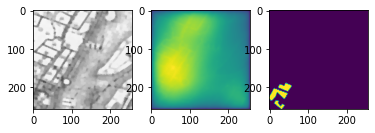

saving best model to checkpoint.pth
0m 11s
Epoch 1/99
----------
train: bce: 0.053484, dice: 0.857869, loss: 0.455676
LR 0.0001
val: bce: 0.049070, dice: 0.864752, loss: 0.456911


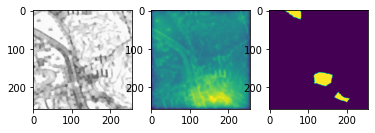

saving best model to checkpoint.pth
0m 11s
Epoch 2/99
----------
train: bce: 0.050259, dice: 0.792006, loss: 0.421133
LR 0.0001
val: bce: 0.055510, dice: 0.759500, loss: 0.407505


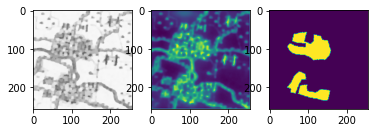

saving best model to checkpoint.pth
0m 11s
Epoch 3/99
----------
train: bce: 0.049201, dice: 0.687167, loss: 0.368184
LR 0.0001
val: bce: 0.056411, dice: 0.692746, loss: 0.374578


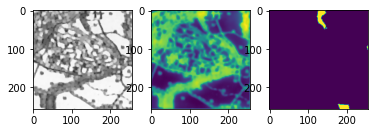

saving best model to checkpoint.pth
0m 11s
Epoch 4/99
----------
train: bce: 0.048215, dice: 0.636431, loss: 0.342323
LR 0.0001
val: bce: 0.051072, dice: 0.668288, loss: 0.359680


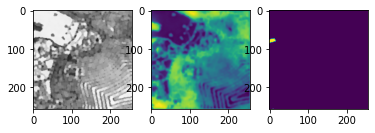

saving best model to checkpoint.pth
0m 11s
Epoch 5/99
----------
train: bce: 0.047316, dice: 0.603641, loss: 0.325479
LR 0.0001
val: bce: 0.045889, dice: 0.611319, loss: 0.328604


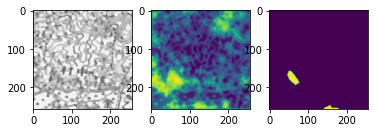

saving best model to checkpoint.pth
0m 11s
Epoch 6/99
----------
train: bce: 0.044108, dice: 0.585704, loss: 0.314906
LR 0.0001
val: bce: 0.046832, dice: 0.598561, loss: 0.322697


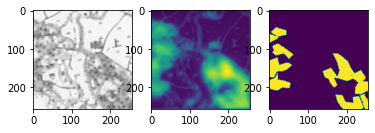

saving best model to checkpoint.pth
0m 11s
Epoch 7/99
----------
train: bce: 0.043697, dice: 0.589093, loss: 0.316395
LR 0.0001
val: bce: 0.042431, dice: 0.586524, loss: 0.314477


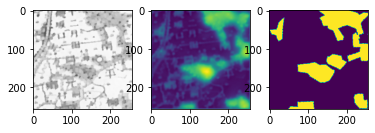

saving best model to checkpoint.pth
0m 11s
Epoch 8/99
----------
train: bce: 0.039908, dice: 0.551662, loss: 0.295785
LR 0.0001
val: bce: 0.047733, dice: 0.638154, loss: 0.342944
0m 10s
Epoch 9/99
----------
train: bce: 0.040694, dice: 0.568926, loss: 0.304810
LR 0.0001
val: bce: 0.045113, dice: 0.595783, loss: 0.320448
0m 10s
Epoch 10/99
----------
train: bce: 0.042733, dice: 0.558680, loss: 0.300706
LR 0.0001
val: bce: 0.042442, dice: 0.544051, loss: 0.293247


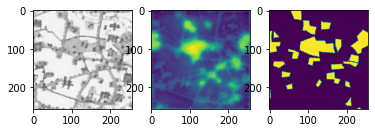

saving best model to checkpoint.pth
0m 11s
Epoch 11/99
----------
train: bce: 0.049214, dice: 0.628501, loss: 0.338857
LR 0.0001
val: bce: 0.043038, dice: 0.585701, loss: 0.314370
0m 10s
Epoch 12/99
----------
train: bce: 0.040627, dice: 0.549843, loss: 0.295235
LR 0.0001
val: bce: 0.041586, dice: 0.597258, loss: 0.319422
0m 10s
Epoch 13/99
----------
train: bce: 0.041132, dice: 0.547692, loss: 0.294412
LR 0.0001
val: bce: 0.041816, dice: 0.590685, loss: 0.316250
0m 10s
Epoch 14/99
----------
train: bce: 0.038288, dice: 0.553874, loss: 0.296081
LR 0.0001
val: bce: 0.042079, dice: 0.565893, loss: 0.303986
0m 10s
Epoch 15/99
----------
train: bce: 0.038961, dice: 0.542913, loss: 0.290937
LR 0.0001
val: bce: 0.040224, dice: 0.588056, loss: 0.314140
0m 10s
Epoch 16/99
----------
train: bce: 0.037983, dice: 0.532422, loss: 0.285203
LR 0.0001
val: bce: 0.038570, dice: 0.527340, loss: 0.282955


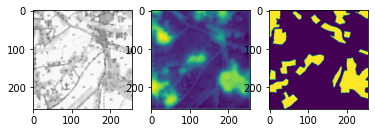

saving best model to checkpoint.pth
0m 11s
Epoch 17/99
----------
train: bce: 0.038655, dice: 0.536149, loss: 0.287402
LR 0.0001
val: bce: 0.044244, dice: 0.552104, loss: 0.298174
0m 10s
Epoch 18/99
----------
train: bce: 0.041049, dice: 0.549881, loss: 0.295465
LR 0.0001
val: bce: 0.037753, dice: 0.552700, loss: 0.295227
0m 10s
Epoch 19/99
----------
train: bce: 0.037323, dice: 0.527894, loss: 0.282609
LR 1e-05
val: bce: 0.039493, dice: 0.538456, loss: 0.288975
0m 10s
Epoch 20/99
----------
train: bce: 0.036119, dice: 0.504048, loss: 0.270084
LR 1e-05
val: bce: 0.036839, dice: 0.544894, loss: 0.290866
0m 10s
Epoch 21/99
----------
train: bce: 0.036494, dice: 0.529634, loss: 0.283064
LR 1e-05
val: bce: 0.035711, dice: 0.519788, loss: 0.277750


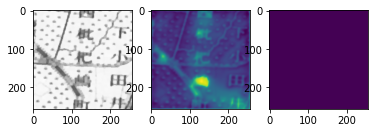

saving best model to checkpoint.pth
0m 11s
Epoch 22/99
----------
train: bce: 0.036454, dice: 0.513060, loss: 0.274757
LR 1e-05
val: bce: 0.038543, dice: 0.562756, loss: 0.300650
0m 10s
Epoch 23/99
----------
train: bce: 0.035958, dice: 0.519852, loss: 0.277905
LR 1e-05
val: bce: 0.037522, dice: 0.522245, loss: 0.279884
0m 10s
Epoch 24/99
----------
train: bce: 0.036236, dice: 0.523675, loss: 0.279956
LR 1e-05
val: bce: 0.038451, dice: 0.525193, loss: 0.281822
0m 10s
Epoch 25/99
----------
train: bce: 0.036669, dice: 0.508465, loss: 0.272567
LR 1e-05
val: bce: 0.037135, dice: 0.516887, loss: 0.277011


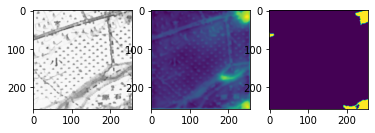

saving best model to checkpoint.pth
0m 11s
Epoch 26/99
----------
train: bce: 0.036675, dice: 0.515801, loss: 0.276238
LR 1e-05
val: bce: 0.037659, dice: 0.560439, loss: 0.299049
0m 10s
Epoch 27/99
----------
train: bce: 0.037360, dice: 0.516873, loss: 0.277117
LR 1e-05
val: bce: 0.036935, dice: 0.524207, loss: 0.280571
0m 10s
Epoch 28/99
----------
train: bce: 0.035987, dice: 0.527822, loss: 0.281905
LR 1e-05
val: bce: 0.035472, dice: 0.529537, loss: 0.282505
0m 10s
Epoch 29/99
----------
train: bce: 0.035682, dice: 0.488178, loss: 0.261930
LR 1e-05
val: bce: 0.035460, dice: 0.535414, loss: 0.285437
0m 10s
Epoch 30/99
----------
train: bce: 0.036441, dice: 0.526485, loss: 0.281463
LR 1e-05
val: bce: 0.037268, dice: 0.540339, loss: 0.288804
0m 10s
Epoch 31/99
----------
train: bce: 0.035555, dice: 0.512544, loss: 0.274050
LR 1e-05
val: bce: 0.036879, dice: 0.497436, loss: 0.267157


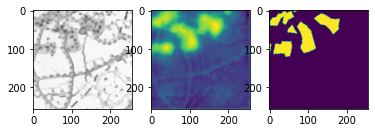

saving best model to checkpoint.pth
0m 11s
Epoch 32/99
----------
train: bce: 0.035907, dice: 0.496681, loss: 0.266294
LR 1e-05
val: bce: 0.035037, dice: 0.542650, loss: 0.288843
0m 11s
Epoch 33/99
----------
train: bce: 0.036040, dice: 0.502482, loss: 0.269261
LR 1e-05
val: bce: 0.035523, dice: 0.516163, loss: 0.275843
0m 10s
Epoch 34/99
----------
train: bce: 0.035539, dice: 0.521184, loss: 0.278361
LR 1e-05
val: bce: 0.035443, dice: 0.574339, loss: 0.304891
0m 10s
Epoch 35/99
----------
train: bce: 0.035206, dice: 0.512315, loss: 0.273760
LR 1e-05
val: bce: 0.036613, dice: 0.527760, loss: 0.282187
0m 10s
Epoch 36/99
----------
train: bce: 0.035503, dice: 0.514370, loss: 0.274937
LR 1e-05
val: bce: 0.035622, dice: 0.567409, loss: 0.301515
0m 10s
Epoch 37/99
----------
train: bce: 0.035897, dice: 0.506786, loss: 0.271342
LR 1e-05
val: bce: 0.036061, dice: 0.566064, loss: 0.301063
0m 10s
Epoch 38/99
----------
train: bce: 0.035059, dice: 0.514529, loss: 0.274794
LR 1e-05
val: bce: 0.03

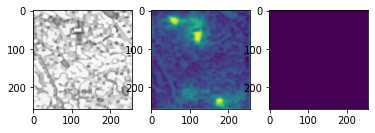

saving best model to checkpoint.pth
0m 11s
Epoch 42/99
----------
train: bce: 0.035658, dice: 0.500539, loss: 0.268099
LR 1.0000000000000002e-06
val: bce: 0.037060, dice: 0.496380, loss: 0.266720
0m 11s
Epoch 43/99
----------
train: bce: 0.034716, dice: 0.529139, loss: 0.281927
LR 1.0000000000000002e-06
val: bce: 0.035201, dice: 0.513347, loss: 0.274274
0m 10s
Epoch 44/99
----------
train: bce: 0.035771, dice: 0.494605, loss: 0.265188
LR 1.0000000000000002e-06
val: bce: 0.036273, dice: 0.564275, loss: 0.300274
0m 10s
Epoch 45/99
----------
train: bce: 0.036054, dice: 0.516608, loss: 0.276331
LR 1.0000000000000002e-06
val: bce: 0.034400, dice: 0.490774, loss: 0.262587
0m 10s
Epoch 46/99
----------
train: bce: 0.034161, dice: 0.523691, loss: 0.278926
LR 1.0000000000000002e-06
val: bce: 0.036729, dice: 0.528136, loss: 0.282433
0m 10s
Epoch 47/99
----------
train: bce: 0.034872, dice: 0.506881, loss: 0.270877
LR 1.0000000000000002e-06
val: bce: 0.037060, dice: 0.533409, loss: 0.285235
0m 1

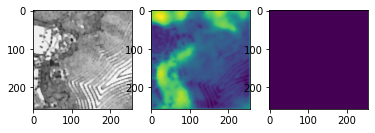

saving best model to checkpoint.pth
0m 11s
Best val loss: 0.257713


In [141]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 2
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=100)

In [138]:
opt = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 3, verbose = 1)

In [ ]:
def fit(model, epochs, opt, loss_func, train_loader, valid_loader, alpha):

    for epoch in range(epochs):
        
        #Going into training mode
        model.train()
        
        train_loss = 0 
        iou = 0
        
        for image, mask in train_loader:
            image = image.to(device)   #Passing the input mini-batch to the GPU
            mask = mask.to(device)   #Passing the label mini-batch to the GPU
            opt.zero_grad()      #Setting the grads to zero to avoid accumulation of gradients
            out = model(image.float())
            loss = loss_func(out.float(), mask.float())    
            train_loss += loss
            
            iou += iou_metric(out, mask)
            iou_rev = 16 - iou_metric(out, mask)
            loss += alpha * iou_rev
            
            loss.backward()
            opt.step()
        
        lr_scheduler.step(train_loss/len(train_loader))   #Setting up lr decay  
        
        model.eval()            #Going into eval mode                            
        with torch.no_grad():   #No backprop
            valid_loss = 0
            valid_iou = 0
            
            for image_val, mask_val in valid_loader:
                image_val = image_val.to(device)  
                image_val_ = image_val[0].squeeze().cpu()
                mask_val = mask_val.to(device)
                mask_val_ = mask_val[0].squeeze().cpu()
                out_val = model(image_val.float())
                # print(out_val.size())
                out_val_ = out_val[0].squeeze().cpu()
                # print(out_val_.size())
                
                plt.subplot(1,3,1)
                plt.imshow( image_val_.permute(1, 2, 0)  )

                plt.subplot(1,3,2)
                plt.imshow(out_val_)
                
                plt.subplot(1,3,3)
                plt.imshow(mask_val_)
                plt.show()

                valid_loss += loss_func(out_val.float(), mask_val.float())
                
                valid_iou += iou_metric(out_val, mask_val)
        
        print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "CV Loss: ", valid_loss/len(valid_loader))
        print("Training IoU: ", iou/len(train_loader), "CV IoU: ", valid_iou/len(valid_loader))



In [ ]:
fit(model, 100, opt, loss_func, train_loader, valid_loader, 5)